In [1]:
!pwd
import sys
sys.executable

/c/Users/shingo/jupyter_notebook/tfgpu_py36_work/02_keras_py/experiment


'C:\\Users\\shingo\\Anaconda3\\envs\\tfgpu20\\python.exe'

# <font color="Red">マルチラベルで分類モデル作成<font>
## ニューラルネットワークを分岐させずにMulti-task learning

In [2]:
#import os
#gpu_num = "3"
#os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_num)

In [3]:
# モジュールimport
import os, sys
sys.path.append(r'C:\Users\shingo\jupyter_notebook\tfgpu_py36_work\02_keras_py')

from dataset import plot_log, prepare_data, util

from transformer import tf_get_train_valid_test as get_train_valid_test
from transformer import tf_my_generator as my_generator

from model import tf_define_model as define_model
from model import tf_multi_loss as multi_loss
from model import tf_my_callback as my_callback
from model import my_metric

from predicter import roc_curve, conf_matrix, ensemble_predict
from predicter import tf_grad_cam as grad_cam
from predicter import tf_base_predict as  base_predict

#from tuning import optuna_train_base, optuna_train_Tox21

import pathlib
#current_dir = pathlib.Path("__file__").resolve().parent
#sys.path.append(r'C:\Users\shingo\jupyter_notebook\tfgpu_py36_work\02_keras_py\Git\keras-squeeze-excite-network')
#import se_inception_v3, se_densenet, se_inception_resnet_v2, se_resnet, se_resnext, se

sys.path.append(r'C:\Users\shingo\Git\mixup-generator')
from mixup_generator import MixupGenerator
from random_eraser import get_random_eraser

%reload_ext autoreload
%autoreload 2

import numpy as np
from tensorflow import keras
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt

## マルチラベルサンプルデータ
- https://blog.manash.me/multi-task-learning-in-keras-implementation-of-multi-task-classification-loss-f1d42da5c3f6
- classes = np.array(['desert', 'mountain', 'sea', 'sunset', 'trees'])

(1600, 100, 100, 3) (400, 100, 100, 3)
[[0 0 1 1 0]
 [0 0 1 0 0]
 [0 1 0 0 0]
 [0 0 1 1 0]
 [0 0 0 1 0]]


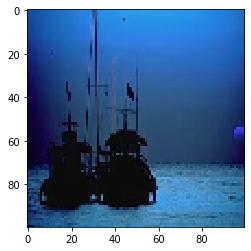

In [4]:
# Downloading and Viewing the dataset

import numpy as np
import matplotlib.pyplot as plt
import h5py
from sklearn.model_selection import train_test_split
#Jupyterでインライン表示するための宣言
%matplotlib inline

def load():
    f = h5py.File("01_code_test/dataset.h5")
    x = f['x'].value
    y = f['y'].value
    f.close()
    
    x_train , x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=100)
    
    # Making the data channel last
    x_train = np.rollaxis(x_train, 1, 4)
    x_test = np.rollaxis(x_test, 1, 4)
    
    # Normalizing data
    x_train = x_train  / 255.0
    x_test = x_test / 255.0
   
    return x_train, x_test, y_train, y_test

x_train, x_test, y_train, y_test = load()
print(x_train.shape, x_test.shape)
print(y_train[:5])
plt.imshow(x_train[0])

### パラメータ設定
- 画像サイズ: 100x100
- エポック数: 10
- モデル（ニューラルネットワーク）
    - Imagenetの学習済みモデル: SEInceptionV3
    - 全結合層: 1層（各層のニューロンの数は1024。各層にdropoutを0.5倍、重みの初期値はhe_normal(He の正規分布)、L2正則化=1e-4）
    - 重みは全層学習させる（fine-tuningなし）
    - 出力層の活性化関数: sigmoid（マルチラベルなので）
    - 出力層の重みの初期値はzero
- オプティマイザ: SGD
    - 学習率: 0.01
- データ水増し
    - 画像の剪断（shear_range=0.2）
    - 拡大縮小（zoom_range=[0.5, 1.9]）
    - 回転（rotation_range=60）
    - 上下反転（horizontal_flip=True）
    - 左右反転（vertical_flip=True）
    - 画像の一部矩形領域を隠す（random_erasing)
- callback
    - keras.callbacks.TerminateOnNaN: lossがNaNになった時に訓練を終了する
    - keras.callbacks.ModelCheckpoint: val_loss最少になるモデルを保存する
    - keras.callbacks.EarlyStopping: val_lossが100エポック更新されなければ学習停止する
    - cosine_annealing: lr*0.01 になるまで段階的に学習率下げる
    - keras.callbacks.CSVLogger: 各エポックの結果をcsvファイルに保存する
    

In [5]:
# 出力ディレクトリ
out_dir = r'D:\work\kaggle_data\tf_multi_label_test'
os.makedirs(out_dir, exist_ok=True)

# batch_size
train_batch_size=50
valid_batch_size=50

# エポック数
epochs=10#250

# 入力層のサイズ
shape=[100, 100, 3]

# クラス数
num_classes=5
task_name_list=['desert', 'mountain', 'sea', 'sunset', 'trees']

# Fine-tuning する学習済みモデル
#choice_model='EfficientNet'# ['VGG16','ResNet50','InceptionV3','Xception','InceptionResNetV2','NASNetLarge','SEResNet154','SEInceptionV3','SEInceptionResNetV2']
choice_model='VGG16'

# 重みは全層学習させる（重みunfreeze開始レイヤーを番号で指定できる）
trainable='all'# [249]

# GradCamでモデルの注目点を切りだす最後の畳み込み層
layer_name = 'top_activation' #'mixed10'

## 全結合層のパラメータ
# pooling方法
fcpool='GlobalAveragePooling2D'
# 全結像層
fcs = [1024]
# 全結合層のニューロンの数とdropout rate
drop, is_add_batchnorm, kernel_init, l2_rate = 0.5, True, 'he_normal', 1e-4

# 出力層の活性化関数
activation = 'sigmoid'
pred_kernel_initializer='zeros'
pred_l2_rate=1e-4

# optimizer のパラメータ
choice_optim='sgd'
lr = 0.01
decay = 0.0

# GPUの数
gpu_num = '1'
gpu_count=len(gpu_num.split(','))
print('gpu_count:', gpu_count)

# ImageDataGenerator のデータ水増しオプション
horizontal_flip=True
vertical_flip=True
rotation_range=60
zoom_range=[0.5, 1.9]
shear_range=0.2

## コールバックの設定
# keras.callbacks.ModelCheckpoint
check_monitor='val_loss' # val_loss最少になるモデルを保存する

# keras.callbacks.EarlyStopping
early_monitor='val_loss' # val_lossが100エポック更新されなければ学習停止する
early_stopping_pati=100


gpu_count: 1


### モデル定義

In [6]:
keras.backend.clear_session()

model, orig_model = define_model.get_fine_tuning_model(out_dir, shape[0], shape[1], shape[2], num_classes
                                                        , choice_model, trainable
                                                        , fcs=fcs
                                                        , fcpool=fcpool
                                                        , drop=drop, is_add_batchnorm=is_add_batchnorm, kernel_init=kernel_init, l2_rate=l2_rate
                                                        , pred_kernel_initializer=pred_kernel_initializer, pred_l2_rate=pred_l2_rate
                                                        , activation=activation 
                                                        , gpu_count=gpu_count
                                                        #, skip_bn=skip_bn
                                                        )
# オプティマイザ
optim = define_model.get_optimizers(choice_optim, lr=lr, decay=decay)
#lr_metric = my_metric.get_lr_metric(optim)

# モデルコンパイル
model.compile(loss=multi_loss.build_masked_loss(K.binary_crossentropy),
              optimizer=optim,
              metrics=['binary_accuracy', multi_loss.masked_accuracy])#, lr_metric])

# callback
cb = []

if gpu_count > 1:
    # マルチGPUでModelCheckpoint使うためのコールバック
    weight_dir = os.path.join(out_dir, 'model_weight')
    os.makedirs(weight_dir, exist_ok=True)
    cb.append(my_callback.MyCheckPoint(orig_model, weight_dir))
    
    # batch_sizeは並列で処理を行うために元々のbatch_sizeをGPUの数だけ掛ける
    train_batch_size = train_batch_size * gpu_count
    valid_batch_size = valid_batch_size * gpu_count
else:
    cb.append(keras.callbacks.TerminateOnNaN())
    cb.append(keras.callbacks.ModelCheckpoint(filepath=os.path.join(out_dir, 'best_model.h5'), monitor=check_monitor, save_best_only=True))#, monitor='val_acc'
    cb.append(keras.callbacks.EarlyStopping(monitor=early_monitor, patience=early_stopping_pati , verbose=1))
    # 学習率をエポック増やすごとにコサインカーブのように上げ下げする
    ## 引数なしならlr*0.01まで下げるだけ
    cb.append(my_callback.cosine_annealing())
    
    # epochごとに学習曲線保存する自作callback
    cb.append(my_callback.learning_curve_plot(os.path.join(out_dir, 'learning_curve.png')))
    
    # ログを保存するカスタムコールバック
    cb.append(my_callback.tsv_logger(os.path.join(out_dir, 'tsv_logger.tsv')))
    
cb.append(keras.callbacks.CSVLogger(os.path.join(out_dir, 'history.tsv'), separator='\t'))
print(cb)

----- model_param -----
output_dir = D:\work\kaggle_data\tf_multi_label_test
img_rows img_cols channels = 100 100 3
num_classes = 5
choice_model trainable = VGG16 all
fcs = [1024]
fcpool = GlobalAveragePooling2D
pred_kernel_initializer pred_l2_rate = zeros 0.0001
activation = sigmoid
gpu_count = 1
skip_bn = True
n_multitask = 1
----- FC_layers -----
dence dropout is_add_batchnorm kernel_initializer l2_rate = 1024 0.5 True he_normal 0.0001
---- choice_optim = sgd ----
sgd_lr sgd_momentum sgd_decay sgd_nesterov = 0.01 0.9 0.0 True
[<tensorflow.python.keras.callbacks.TerminateOnNaN object at 0x00000226798B0248>, <tensorflow.python.keras.callbacks.ModelCheckpoint object at 0x0000022679924688>, <tensorflow.python.keras.callbacks.EarlyStopping object at 0x0000022679937208>, <model.tf_my_callback.cosine_annealing.<locals>._CosineAnnealing object at 0x0000022679937148>, <model.tf_my_callback.learning_curve_plot.<locals>._LearningCurvePlotter object at 0x00000226799370C8>, <model.tf_my_callback

In [7]:
# モデルのサマリー
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0     

In [8]:
# モデルのレイヤー名と番号
count= 0
for layer in model.layers:
    print(count, layer.name)
    count+=1

0 input_1
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_pool
11 block4_conv1
12 block4_conv2
13 block4_conv3
14 block4_pool
15 block5_conv1
16 block5_conv2
17 block5_conv3
18 block5_pool
19 FC_avg
20 FC0_dence
21 FC0_batchNormalization
22 FC0_act
23 FC0_dropout
24 pred


### データ管理クラス定義
- d_cls.X_train: train set の画像データ（d_cls.X_train.shape:[11764, 331, 331, 3]）
- d_cls.X_valid: validation set の画像データ（d_cls.X_valid.shape:[296, 331, 331, 3]）
- d_cls.X_test: test set の画像データ（d_cls.X_test.shape:[647, 331, 331, 3]）
- d_cls.train_gen: train set のImageDataGenerator
- d_cls.valid_gen: validation set のImageDataGenerator

In [9]:
%%time
d_cls = get_train_valid_test.LabeledDataset(shape, train_batch_size, valid_batch_size
                                            , train_samples=x_train.shape[0]
                                            , valid_samples=x_test.shape[0]
                                           )
d_cls.X_train = x_train
d_cls.y_train = y_train
d_cls.X_valid = x_test
d_cls.y_valid = y_test

# ImageDataGenerator のオプションを辞書型で詰める
# get_random_eraserでd_clsの値使うのでここで宣言しないとエラーになる
IDG_options={'horizontal_flip': horizontal_flip
             , 'vertical_flip': vertical_flip
             , 'rotation_range': rotation_range
             , 'zoom_range': zoom_range
             , 'shear_range': shear_range
             #, 'preprocessing_function': get_random_eraser(v_l=np.min(d_cls.X_train), v_h=np.max(d_cls.X_train))
            }

d_cls.create_generator(IDG_options=IDG_options)

train_steps_per_epoch : 32
valid_steps_per_epoch : 8
----- train_ImageDataGenerator -----
use_mixup: False
IDG_options: {'horizontal_flip': True, 'vertical_flip': True, 'rotation_range': 60, 'zoom_range': [0.5, 1.9], 'shear_range': 0.2}
Wall time: 110 ms


(<keras_preprocessing.image.numpy_array_iterator.NumpyArrayIterator at 0x224d8ef6c88>,
 <keras_preprocessing.image.numpy_array_iterator.NumpyArrayIterator at 0x224d8ef69c8>)

In [10]:
x, y = next(d_cls.train_gen)
print(x, y)
print(x.shape, y.shape)
#from tensorflow.python.keras.utils.data_utils import Sequence

[[[[8.00035715e-01 6.94117665e-01 5.33333361e-01]
   [8.03921580e-01 6.94117665e-01 5.33333361e-01]
   [8.03921580e-01 6.94117665e-01 5.33333361e-01]
   ...
   [1.11454032e-01 3.69442254e-02 4.87089306e-02]
   [7.20957369e-02 7.19279610e-03 1.57552138e-02]
   [5.98993748e-02 2.17595361e-02 2.87697725e-02]]

  [[8.00000012e-01 6.94351077e-01 5.33450067e-01]
   [8.00324261e-01 6.94117665e-01 5.33333361e-01]
   [8.03921580e-01 6.94117665e-01 5.33333361e-01]
   ...
   [1.01081260e-01 2.94893533e-02 4.02814262e-02]
   [5.76954670e-02 7.57444650e-03 1.54175842e-02]
   [8.01410899e-02 6.11549616e-02 6.49211034e-02]]

  [[8.00269127e-01 7.02229917e-01 5.37524045e-01]
   [8.00000012e-01 6.94117665e-01 5.33333361e-01]
   [8.00612807e-01 6.94117665e-01 5.33333361e-01]
   ...
   [6.21547811e-02 8.85479618e-04 8.72861780e-03]
   [6.59860149e-02 3.39328088e-02 3.99286076e-02]
   [1.15826137e-01 1.09816387e-01 1.10338435e-01]]

  ...

  [[8.63804877e-01 8.27450991e-01 7.52198994e-01]
   [8.69278669e-

In [11]:
y_train.shape

(1600, 5)

In [15]:
model.fit(x_train, y_train, epochs=2)

Train on 1600 samples
Epoch 1/2
  32/1600 [..............................] - ETA: 11s

TypeError: Input 'y' of 'Mul' Op has type float32 that does not match type int64 of argument 'x'.

### 学習実行

In [14]:
%%time
model.fit_generator(d_cls.train_gen
                    , steps_per_epoch=d_cls.train_steps_per_epoch()
                    , epochs=epochs
                    , validation_data=d_cls.valid_gen
                    , validation_steps=d_cls.valid_steps_per_epoch()
                    , callbacks=cb
                    , verbose=2)

AttributeError: 'NumpyArrayIterator' object has no attribute 'shape'

In [13]:
import os
import matplotlib
#Jupyterでインライン表示するための宣言
%matplotlib inline
#plot_log.plot_results(out_dir, os.path.join(out_dir, 'history.tsv'))
plot_log.plot_results(out_dir, os.path.join(out_dir, 'tsv_logger.tsv'))

FileNotFoundError: [Errno 2] File b'D:\\work\\kaggle_data\\tf_multi_label_test\\tsv_logger.tsv' does not exist: b'D:\\work\\kaggle_data\\tf_multi_label_test\\tsv_logger.tsv'

### 推論実行

### test set（今回はtest set なし）
- タスクごとの混同行列とROC図も作成し、./< out_dir >/predict/test ディレクトリに出力

In [ ]:
#%%time
## -------- 推論 --------
#model = keras.models.load_model(os.path.join(out_dir, 'best_model.h5'), compile=False)
#
## 推論結果出力先
#out_predict_dir = os.path.join(out_dir, 'predict/test')
#
## 出力層のニューラルネットワークに分岐がない場合のpredict
#y_test_list, y_pred_list = multi_predict.no_branch_set_predict(model, d_cls.X_test, d_cls.y_test, out_predict_dir)
#
## -------- 混同行列 --------
## 分類クラス 0(negative), 1(positive), -1(ラベル欠損)
#classes = [0,1,-1]
#
## タスクごとのpredictのスコア(y_pred)と正解ラベル(y_true)から混同行列をファイル出力
#conf_matrix.binary_multi_confmx(classes, y_test_list, y_pred_list, out_predict_dir)

In [ ]:
## -------- ROC_AUC --------
## タスクごとのpredictのスコア(y_pred)と正解ラベル(y_true)からROC_AUCファイル出力
#roc_curve.plot_roc(os.path.join(out_predict_dir, 'ROC_curve.png'), y_test_list, y_pred_list)

### test set GradCam
- GradCam実行した画像は./< out_dir >/grad_cam/ ディレクトリに出力

#### ためしに1件実行

In [ ]:
#K.set_learning_phase(0) #Test時には0にセット modelロード前にこれがないとGradCamエラーになる
#
## GradCam出力先
#out_grad_cam_dir = os.path.join(out_dir, 'grad_cam/test')
#
#model = keras.models.load_model(os.path.join(out_dir, 'best_model.h5'), compile=False)
#
## 3次元numpy.array型の画像データ（*1./255.前）
#x = d_cls.X_test[0]*255.0
#input_img_name = 'test0'
#
#y_true = d_cls.y_test[0]
#
## 1画像について各タスクのGradCamを計算
#grad_cam.nobranch_multi_grad_cam(model, out_grad_cam_dir, input_img_name, x, y_true, layer_name, shape[0], shape[1])

#### test set 全件GradCam実行（十数時間かかる）

In [ ]:
#%%time
#K.set_learning_phase(0) #Test時には0にセット modelロード前にこれがないとGradCamエラーになる
#
## GradCam出力先
#out_grad_cam_dir = os.path.join(out_dir, 'grad_cam/test_all')
#
#model = keras.models.load_model(os.path.join(out_dir, 'best_model.h5'), compile=False)
#
#for i,  x in enumerate(d_cls.X_test):
#    # 3次元numpy.array型の画像データ（*1./255.前）
#    x = x*255.0
#
#    # ファイル名
#    file_path = test_files[test_files.index[i]]# test_filesはindexが0始まりではないので.index[i]で要素アクセス
#    input_img_name = os.path.basename(file_path)
#    print('input_img_name:', input_img_name)
#    
#    # 正解ラベル
#    y_true = d_cls.y_test[i]
#
#    # 1画像について各タスクのGradCamを計算
#    grad_cam_img = grad_cam.nobranch_multi_grad_cam(model, out_grad_cam_dir, input_img_name, x, y_true, layer_name, shape[0], shape[1])
#
## 確認用に1枚表示
#plt.figure(figsize=(6, 4))
#plt.imshow(grad_cam_img)
#plt.show()

In [ ]:
model_EfficientNetB3_path = os.path.join(out_dir, 'best_model.h5')
model, orig_model = define_model.get_fine_tuning_model(out_dir, shape[0], shape[1], shape[2], num_classes
                                                        , choice_model, trainable
                                                        , fcs=fcs
                                                        , fcpool=fcpool
                                                        , drop=drop, is_add_batchnorm=is_add_batchnorm, kernel_init=kernel_init, l2_rate=l2_rate
                                                        , pred_kernel_initializer=pred_kernel_initializer, pred_l2_rate=pred_l2_rate
                                                        , activation=activation 
                                                        , gpu_count=gpu_count
                                                        #, skip_bn=skip_bn
                                                        )
model.summary()

In [ ]:
model.load_weights(model_EfficientNetB3_path)

### validation set
- タスクごとの混同行列とROC図も作成し、./< out_dir >/predict/validation ディレクトリに出力

In [ ]:
%%time
# -------- 推論 --------
#model = keras.models.load_model(os.path.join(out_dir, 'best_model.h5'), compile=False)

# 推論結果出力先
out_predict_dir = os.path.join(out_dir, 'predict/validation')

# 出力層のニューラルネットワークに分岐がない場合のpredict
y_valid_list, y_pred_list = base_predict.no_branch_set_predict(model, d_cls.X_valid, d_cls.y_valid, out_predict_dir)

# -------- 混同行列 --------
# 分類クラス 0(negative), 1(positive), -1(ラベル欠損)
classes = [0,1,-1]

# タスクごとのpredictのスコア(y_pred)と正解ラベル(y_true)から混同行列をファイル出力
conf_matrix.binary_multi_confmx(classes, y_valid_list, y_pred_list, out_predict_dir)

In [ ]:
# -------- ROC_AUC --------
# タスクごとのpredictのスコア(y_pred)と正解ラベル(y_true)からROC_AUCファイル出力
roc_curve.plot_roc(os.path.join(out_predict_dir, 'ROC_curve.png'), y_valid_list, y_pred_list
                  , task_name_list=task_name_list
                  )

### validation set GradCam
- GradCam実行した画像は./< out_dir >/grad_cam/ ディレクトリに出力

#### ためしに1件実行

In [15]:
#K.set_learning_phase(0) #Test時には0にセット modelロード前にこれがないとGradCamエラーになる

# GradCam出力先
out_grad_cam_dir = os.path.join(out_dir, 'grad_cam/validation')

#model = keras.models.load_model(os.path.join(out_dir, 'best_model.h5'), compile=False)
# Custom Functionを使ったmodelを別環境で使用するには、modelをロードする際に引数として、[custom_objects]を指定するがある
# https://qiita.com/tkinjo1/items/51f9e2d0d9c4659bde8a
#model = keras.models.load_model(os.path.join(output_dir, 'finetuning.h5'), custom_objects={'lr':lr_metric})

# 3次元numpy.array型の画像データ（*1./255.前）
x = d_cls.X_valid[0]*255.0
input_img_name = 'valid0'

y_true = d_cls.y_valid[0]

# 1画像について各タスクのGradCamを計算
layer_name = 'top_activation'
grad_cam.nobranch_multi_grad_cam(model, out_grad_cam_dir, input_img_name, x, y_true, layer_name, shape[0], shape[1])

RuntimeError: tf.gradients is not supported when eager execution is enabled. Use tf.GradientTape instead.

#### validation set 全件GradCam実行（数時間かかる）

In [14]:
%%time
#K.set_learning_phase(0) #Test時には0にセット modelロード前にこれがないとGradCamエラーになる

# GradCam出力先
out_grad_cam_dir = os.path.join(out_dir, 'grad_cam/validation_all')

#model = keras.models.load_model(os.path.join(out_dir, 'best_model.h5'), compile=False)

for i,  x in enumerate(d_cls.X_valid):
    # 3次元numpy.array型の画像データ（*1./255.前）
    x = x*255.0
    
    # ファイル名
    file_path = validation_files[validation_files.index[i]]# validation_filesはindexが0始まりではないので.index[i]で要素アクセス
    input_img_name = os.path.basename(file_path)
    print('input_img_name:', input_img_name)
    
    # 正解ラベル
    y_true = d_cls.y_valid[i]

    # 1画像について各タスクのGradCamを計算
    grad_cam_img = grad_cam.nobranch_multi_grad_cam(model, out_grad_cam_dir, input_img_name, x, y_true, layer_name, shape[0], shape[1])

# 確認用に1枚表示
plt.figure(figsize=(6, 4))
plt.imshow(grad_cam_img)
plt.show()

NameError: name 'validation_files' is not defined